### Battle simulation

In [2]:
# Model design
import agentpy as ap

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import IPython

In [40]:
class Soldier(ap.Agent):
    
    def setup(self):
        # team:
        # 'blue' -> 0
        # 'red' -> 1
        self.team = 'blue'
        # Initialize an attribute with a parameter
        self.health = 100
        self.damage = 12        
        
        # status:
        #   2 - alive and fighting (default)
        #   1 - surrendered and running away
        #   0 - dead
        self.status = 2

        # self.endurance = 100
        # self.strength = 100
        # self.speed = 100
        # self.itd = 123
        # self.itp = 321

    def attack(self, enemy):
        enemy.health -= self.damage
        # if soldier killed enemy
        if enemy.health <= 0:
            enemy.status = 0
    
    # def move(self, x, y):
    #     return     
        
    def agent_method(self):
        # Define custom actions here
        pass

In [71]:
class BattleModel(ap.Model):
    
    def setup(self):
        # Create soldiers
        # count of soldiers in red team
        n_red_team = self.p['n_red_team']
        # count of soldiers in blue team
        n_blue_team = self.p['n_blue_team']
        # all soldiers
        n_soldiers = n_red_team + n_blue_team
        # create soldiers
        self.soldiers =  ap.AgentList(self, n_soldiers, Soldier)
        # soldier teams
        self.red_soldiers = []
        self.blue_soldiers = []
        
        # assign team for each soldier
        for i, soldier in enumerate(self.soldiers):
            # assign soldiers to red team
            if i < n_red_team:
                soldier.team = 'red'
                self.red_soldiers.append(soldier)
            # assign soldiers to blue team
            else:
                soldier.team = 'blue'
                self.blue_soldiers.append(soldier)
        
        # Create grid (battlefield)
        self.battlefield = ap.Grid(self, [self.p.size]*2, track_empty=True)      
        self.battlefield.add_agents(self.soldiers, random=True, empty=True)

        # Initiate a dynamic variable for all trees
        # status:
        #   2 - alive and fighting (default)
        #   1 - surrendered and running away
        #   0 - dead
        self.soldiers.status = 2 
        
        # # Start a fire from the left side of the grid
        # unfortunate_trees = self.forest.agents[0:self.p.size, 0:2]
        # unfortunate_trees.condition = 1 
    
    def step(self):
        # TODO: now whole red team has privilege to attack first
        # mixing the soldiers list before performing actions might help to level the playing field 

        # each red soldier attack
        for red_soldier in self.red_soldiers:
            # LOGGING
            # print("ajaj")
            # print(self.battlefield.neighbors(red_soldier, distance=1))
            # print(red_soldier)
            for neighbor in self.battlefield.neighbors(red_soldier, distance=1).to_list():
                if neighbor.team == 'blue':
                    # attack the first found neigbour from opposite team (break to not attack all neigbours but only the first one)
                    red_soldier.attack(neighbor)
                    break
            # TODO: soldier move after executing the attack
            # red_soldier.move()
        
        # each blue soldier attack
        for blue_soldier in self.blue_soldiers:
            for neighbor in self.battlefield.neighbors(blue_soldier, distance=1).to_list():
                if neighbor.team == 'red':
                    # attack the first found neigbour from opposite team (break to not attack all neigbours but only the first one)
                    red_soldier.attack(neighbor)
                    break
            # TODO: soldier move after executing the attack
            # red_soldier.move()
        

        # TODO: remove dead soldiers form self.soldiers and self.red/blue__team 
        # as they cannot interact with environment anymore
            
        # Stop simulation if there's only one team left
        if 0 in (len(self.red_soldiers), len(self.blue_soldiers)): 
            self.stop()
            
            
    def end(self):
        # Document a measure at the end of the simulation
        red_team_survivors = len(self.red_soldiers)
        blue_team_survivors = len(self.blue_soldier)
        self.report('Percentage of red team survivors', 
                    red_team_survivors / len(self.agents))
        self.report('Percentage of blue team survivors', 
                    blue_team_survivors / len(self.agents))
        self.report('Won team', 
                    'blue' if blue_team_survivors > 0 else 'red')

## Single-run animation

In [72]:
# Define parameters

parameters = {
    'n_red_team': 50, # number of team_1 soldiers
    'n_blue_team': 45, # number of team_2 soldiers
    'size': 30, 
    'steps': 100,
}

In [73]:
# Create single-run animation with custom colors
def animation_plot(model, ax):
    # TODO: assign different color for each team in visualisation
    attr_grid = model.battlefield.attr_grid('status')
    color_dict = {0:'#0048ff', 2:'#fc0303', None:'#423c3c'}
    ap.gridplot(attr_grid, ax=ax, color_dict=color_dict, convert=True)
    ax.set_title(f"Battle simulation\n"
                 # f"Time-step: {model.t}, Trees left: "
                 # f"{len(model.agents.select(model.agents.condition == 0))}"
                )

fig, ax = plt.subplots() 
model = BattleModel(parameters)
animation = ap.animate(model, fig, ax, animation_plot)
IPython.display.HTML(animation.to_jshtml(fps=15))

## #TODO: Parameter sweep

In [19]:
# Prepare parameter sample
parameters = {
    'Tree density': ap.Range(0.2, 0.6), 
    'size': 100
}
sample = ap.Sample(parameters, n=30)

In [ ]:
# Perform experiment
exp = ap.Experiment(ForestModel, sample, iterations=40)
results = exp.run()

Scheduled runs: 1200
Completed: 304, estimated time remaining: 0:00:43

In [17]:
# Save and load data
results.save()
results = ap.DataDict.load('ForestModel')

Data saved to ap_output/ForestModel_1
Loading from directory ap_output/ForestModel_1/
Loading info.json - Successful
Loading parameters_constants.json - Successful
Loading parameters_log.json - Successful
Loading parameters_sample.csv - Successful
Loading reporters.csv - Successful


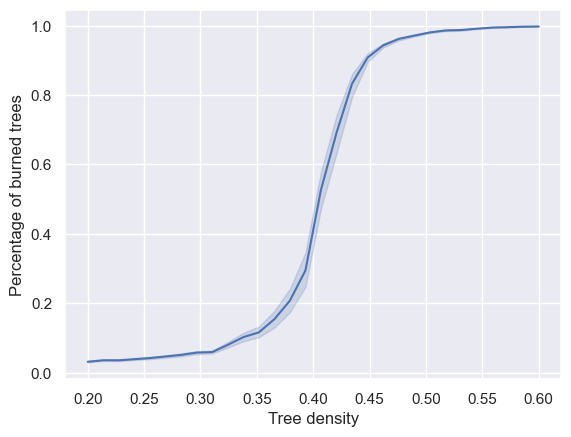

In [18]:
# Plot sensitivity
sns.set_theme()
sns.lineplot(
    data=results.arrange_reporters(), 
    x='Tree density', 
    y='Percentage of burned trees'
);